In [141]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#importing classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [142]:
filename_negs = glob.glob('neg/cv0**.txt')
filename_pos = glob.glob('pos/cv0**.txt')

In [143]:
def makelist(filenames):
    list_of_dfs = []
    for filename in filenames:
        chunk = ""
        with open(filename) as f:
            chunk = f.readlines()
        list_of_dfs.append(chunk)
        
    return list_of_dfs

In [144]:
dfneg = pd.DataFrame([makelist(filename_negs)]).T
dfneg = dfneg.rename(index = str, columns={0: "reviews"})
dfneg['reviews']=[" ".join(review) for review in dfneg['reviews'].values]
dfpos = pd.DataFrame([makelist(filename_pos)]).T
dfpos = dfpos.rename(index = str, columns={0: "reviews"})
dfpos['reviews']=[" ".join(review) for review in dfpos['reviews'].values]

In [145]:
def addsent(val):
    sent = []
    for i in range (0, 100):
        sent.append(val)
    return sent 

In [146]:
dfneg['sentiment'] = addsent(0) #negative sentiment denoted by 0
dfneg['rating'] = np.random.randint(1,3,100)
dfpos['sentiment'] = addsent(1) #positive sentiment denoted by 1
dfpos['rating'] = np.random.randint(4,6,100)


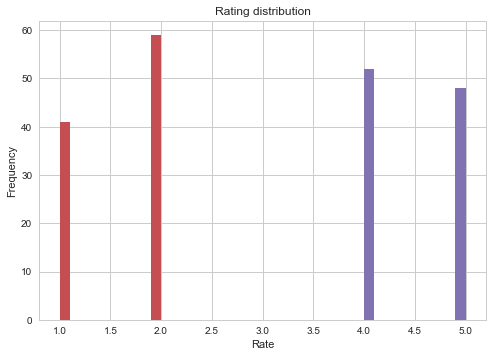

In [155]:
plt.hist(dfneg['rating'])
plt.hist(dfpos['rating'])
plt.title("Rating distribution")
plt.xlabel("Rate")
plt.ylabel("Frequency")
plt.show()

In [147]:
msk = np.random.rand(len(dfneg)) < 0.8

In [148]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', use_idf = True)

In [149]:
dfneg_training = dfneg[msk]
dfneg_test = dfneg[~msk]
dfpos_training = dfpos[msk]
dfpos_test = dfpos[~msk]

In [150]:
#since the data has been divided into training and test set, we can now run a machine learning classifier on our data 

In [151]:
training_data = dfneg_training.append(dfpos_training)
training_data= training_data.sample(frac=1).reset_index(drop=True)
test_data = dfneg_test.append(dfpos_test)
test_data= test_data.sample(frac=1).reset_index(drop=True)
features = vectorizer.fit_transform(training_data.append(test_data).reviews).toarray()
#training_labels = training_data.rating
#test_features = vectorizer.fit_transform(test_data.reviews).toarray()
labels = training_data.append(test_data).rating
X_train, X_test, y_train, y_test = train_test_split(training_data.append(test_data)['reviews'], training_data.append(test_data)['rating'], random_state = 0)

In [133]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [135]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [136]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

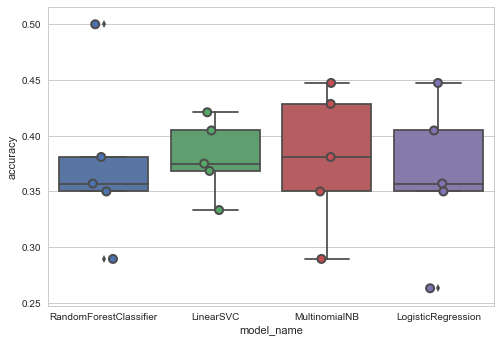

In [137]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [138]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.380514
LogisticRegression        0.364486
MultinomialNB             0.379273
RandomForestClassifier    0.375514
Name: accuracy, dtype: float64